In [2]:
config_name = 'outputs/model_23_2config'
time_horizon = 1000
wanted_shot = '180636'

In [3]:
#import sklearn
import shap

shap.initjs()

/home/hf8585/.conda/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%load_ext autoreload
%autoreload 2
import h5py as h5
import matplotlib.pyplot as plt
import os
import configparser
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import sys
import torch
sys.path.append(os.path.expanduser("~/TMPredictor/survival_tm/auton-survival"))
from auton_survival.preprocessing import Scaler
import optuna
from sklearn.model_selection import ParameterGrid
#sys.path.append('/projects/EKOLEMEN/survival_tm/train_models/auton-survival')
sys.path.append(os.path.expanduser("~/TMPredictor/survival_tm/auton-survival"))
from sklearn.model_selection import ParameterGrid
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from auton_survival.models.dsm import DeepSurvivalMachines
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc
from get_survival_from_shot import get_rt_survival_from_shot, get_cakenn_survival_from_shot
import copy
import metrics_helpers
import seaborn as sns

In [169]:
with open('data/eccd.pkl', 'rb') as f:
    eccd = pickle.load(f)
with open('data/JECCD.pkl', 'rb') as f:
    jeccd = pickle.load(f)

print(eccd.keys())
print(jeccd.keys())

dict_keys(['q', 'qx', 'qy', 'rho', 'rhox', 'rhoy'])
dict_keys(['JECCD', 'jx', 'jy', 'qpsi', 'qx', 'qy'])


In [168]:
with open('data/eccd_2.pkl', 'rb') as f:
    eccd_2 = pickle.load(f)
print(eccd_2.keys())

dict_keys(['q', 'qx', 'qy', 'rho', 'rhox', 'rhoy'])


dict_keys(['JECCD', 'jx', 'jy', 'qpsi', 'qx', 'qy'])
(201, 196)
(260, 65)
[0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055
 0.06  0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1   0.105 0.11  0.115
 0.12  0.125 0.13  0.135 0.14  0.145 0.15  0.155 0.16  0.165 0.17  0.175
 0.18  0.185 0.19  0.195 0.2   0.205 0.21  0.215 0.22  0.225 0.23  0.235
 0.24  0.245 0.25  0.255 0.26  0.265 0.27  0.275 0.28  0.285 0.29  0.295
 0.3   0.305 0.31  0.315 0.32  0.325 0.33  0.335 0.34  0.345 0.35  0.355
 0.36  0.365 0.37  0.375 0.38  0.385 0.39  0.395 0.4   0.405 0.41  0.415
 0.42  0.425 0.43  0.435 0.44  0.445 0.45  0.455 0.46  0.465 0.47  0.475
 0.48  0.485 0.49  0.495 0.5   0.505 0.51  0.515 0.52  0.525 0.53  0.535
 0.54  0.545 0.55  0.555 0.56  0.565 0.57  0.575 0.58  0.585 0.59  0.595
 0.6   0.605 0.61  0.615 0.62  0.625 0.63  0.635 0.64  0.645 0.65  0.655
 0.66  0.665 0.67  0.675 0.68  0.685 0.69  0.695 0.7   0.705 0.71  0.715
 0.72  0.725 0.73  0.735 0.74  0.745 0.75  0.755 0

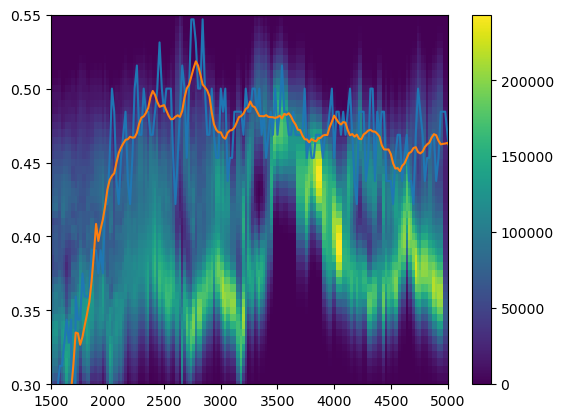

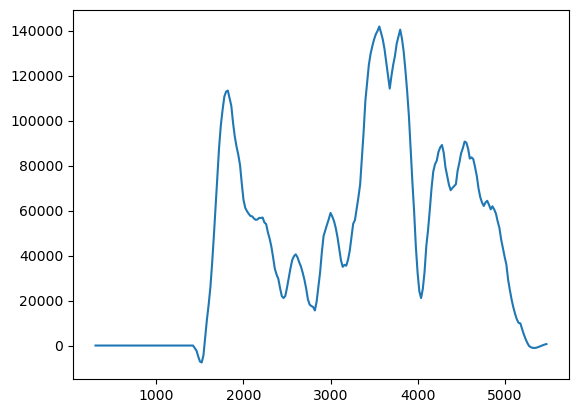

In [48]:
print(jeccd.keys())
print(jeccd['JECCD'].shape)
print(jeccd['qpsi'].shape)
print(jeccd['jy'])
# make a heatmap where x is jeccd['jx'], y is jy, and color is jeccd['JECCD']

plt.figure()
plt.pcolormesh(jeccd['jx'], jeccd['jy'], jeccd['JECCD'])
plt.ylim([0.3, 0.55])
plt.xlim([1500, 5000])
# add heatbar
plt.colorbar()

# for each time in qy, make an array of the qx value at which qpsi is 2
qpsi_2 = []
for i in range(len(jeccd['qy'])):
    qpsi_2.append(jeccd['qx'][np.argmin(np.abs(jeccd['qpsi'][i, :] - 2))])
plt.plot(jeccd['qy'], qpsi_2)

# smooth qpsi_2
from scipy.signal import savgol_filter
qpsi_2_smooth = savgol_filter(qpsi_2, 21, 3)
plt.plot(jeccd['qy'], qpsi_2_smooth)
j_q2 = []
for i, rho in enumerate(qpsi_2_smooth):
    # find the value in jy that is closest to rho
    jy_idx = np.argmin(np.abs(jeccd['jy'] - rho))
    # find the time in jx that is closest to qy[i]
    jx_idx = np.argmin(np.abs(jeccd['jx'] - jeccd['qy'][i]))
    j_q2.append(jeccd['JECCD'][jy_idx, jx_idx])
plt.show()
#plt.plot(jeccd['qy'], j_q2)
plt.plot(jeccd['qy'], savgol_filter(j_q2, 21, 3))
j_eccd_dict = {'time': jeccd['qy'], 'JECCD_q=2': savgol_filter(j_q2, 21, 3)}
# with open('data/j_eccd_q2.pkl', 'wb') as f:
#     pickle.dump(j_eccd_dict, f)

In [4]:
# READ CONFIG
config = configparser.ConfigParser()
config.read(config_name)
database_x_name = config['model']['database_x_name']
database_e_name = config['model']['database_e_name']
database_t_name = config['model']['database_t_name']
database_shots_list_name = config['model']['database_shots_list_name']
output_filename_base = config['model']['output_filename_base']

# LOAD DATABASE
with open(f'/projects/EKOLEMEN/survival_tm_2/data/{database_x_name}.pkl', 'rb') as f:
    x = np.array(pickle.load(f))
with open(f'/projects/EKOLEMEN/survival_tm_2/data/{database_e_name}.pkl', 'rb') as f:
    e = pickle.load(f)
with open(f'/projects/EKOLEMEN/survival_tm_2/data/{database_t_name}.pkl', 'rb') as f:
    t = pickle.load(f)
with open(f'/projects/EKOLEMEN/survival_tm_2/data/{database_shots_list_name}.pkl', 'rb') as f:
    shots_list = pickle.load(f)

start_index = np.where(shots_list == wanted_shot)[0][0]
end_index = len(shots_list) - 1 - np.where(shots_list[::-1] == wanted_shot)[0][0]

specific_shot_x = np.array(x[start_index:end_index])
specific_shot_e = e[start_index:end_index]
specific_shot_t = t[start_index:end_index]

# LOAD MODEL
with open(f'models/{output_filename_base}.pkl', 'rb') as f:
    model = pickle.load(f)[0][0]

Scenario 0 data

In [6]:
# READ CONFIG
config = configparser.ConfigParser()
config.read(config_name)
database_x_name = config['model']['database_x_name']
database_e_name = config['model']['database_e_name']
database_t_name = config['model']['database_t_name']
database_shots_list_name = config['model']['database_shots_list_name']
output_filename_base = config['model']['output_filename_base']

# LOAD MODEL
with open(f'models/{output_filename_base}.pkl', 'rb') as f:
    model = pickle.load(f)[2][0]
    
with open(f'/projects/EKOLEMEN/survival_tm_2/data/scenario0_dict.pkl', 'rb') as f:
    scenario0_dict = pickle.load(f)
with open(f'/projects/EKOLEMEN/survival_tm_2/data/model0_scenario0_x.pkl', 'rb') as f:
    x = pickle.load(f)
# with open(f'/projects/EKOLEMEN/survival_tm_2/data/scenario0_ptdata_dict.pkl', 'rb') as f:
#     scenario0_dict = pickle.load(f)
# with open(f'/projects/EKOLEMEN/survival_tm_2/data/model0_scenario0_pt_x.pkl', 'rb') as f:
#     x = pickle.load(f)

shots_list = scenario0_dict['shots_list']
times_list = scenario0_dict['times_list']
# keep only shots til 199607
# in shots_list find the first index of 199613
if '199613' in shots_list:
    end_index = np.where(shots_list == '199613')[0][0]
else:
    end_index = len(shots_list)
shots_list = shots_list[:end_index]
times_list = times_list[:end_index]
x = x[:end_index]

1374 1547


/home/hf8585/TMPredictor/survival_tm/auton-survival/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


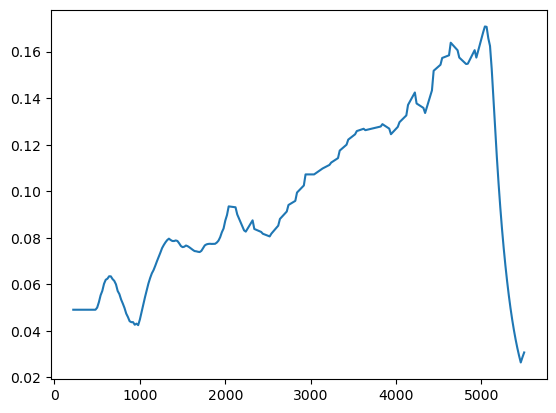

In [8]:
wanted_shot = '199606'

start_index = np.where(shots_list == wanted_shot)[0][0]
end_index = len(shots_list) - 1 - np.where(shots_list[::-1] == wanted_shot)[0][0]

print(start_index, end_index)
x_shot = x[start_index:end_index]
t_shot = times_list[start_index:end_index]
survival_output = model.predict_survival(pd.DataFrame(x), [1000])
survival_output_shot = 1-survival_output[start_index:end_index]
#plt.plot(t_shot, survival_output_shot, label='Survival Probability')
plt.plot(t_shot, metrics_helpers.LP_filter(survival_output_shot, alpha=0.9), label='Survival Probability')

In [9]:
torch_model = model._model.torch_model
from torch.autograd import Variable
def numpy_model(x):

    input_tensor = torch.tensor(x)
    
    # Wrap the tensor in a Variable (optional, often not necessary in PyTorch 1.0+)
    #input_tensor = Variable(input_tensor)
    
    # Pass the input through the PyTorch model
    model_output = torch_model(input_tensor, risk=-1)
    # Convert the output to a NumPy array
    output_array = 1-torch.tensor(model_output).detach().numpy()
    
    return output_array

In [10]:
model_output = numpy_model(np.array(x))

In [11]:
cakenn_prof_signals=[r'$T_e$', r'$T_i$', r'$n_e$', r'$\omega$', r'$\iota$', r'$p$', r'$j_\phi$']
feature_names = cakenn_prof_signals * 33 # this is wrong, just a place holder!!
explainer = shap.Explainer(numpy_model, x, feature_names=feature_names)
#explainer = shap.KernelExplainer(numpy_model, data2, feature_names=feature_names, link='logit')

shap_values = explainer(x)

PermutationExplainer explainer: 1723it [13:46,  2.06it/s]                          


In [12]:
shap_cakenn_names = [r'$T_e$', r'$T_i$', r'$n_e$', r'$Rot$', r'$q$', r'$p$', r'$j$']
new_features = []
for feature in shap_cakenn_names:
    temp = [r'$Core$ ' + feature, r'$Off$-$axis$ ' + feature, r'$Edge$ ' + feature]
    new_features.extend(temp)
print(new_features)

#print(shap_values.feature_names)

['$Core$ $T_e$', '$Off$-$axis$ $T_e$', '$Edge$ $T_e$', '$Core$ $T_i$', '$Off$-$axis$ $T_i$', '$Edge$ $T_i$', '$Core$ $n_e$', '$Off$-$axis$ $n_e$', '$Edge$ $n_e$', '$Core$ $Rot$', '$Off$-$axis$ $Rot$', '$Edge$ $Rot$', '$Core$ $q$', '$Off$-$axis$ $q$', '$Edge$ $q$', '$Core$ $p$', '$Off$-$axis$ $p$', '$Edge$ $p$', '$Core$ $j$', '$Off$-$axis$ $j$', '$Edge$ $j$']


In [13]:
shap_values_copy = copy.deepcopy(shap_values)

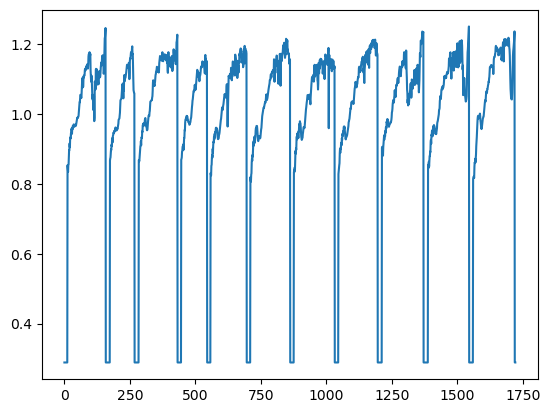

In [17]:
plt.plot(np.mean(shap_values_copy.data[:, 4*33:5*33], axis=1))

In [18]:
i=4
mean_q_values = np.mean(shap_values_copy.data[:, i*33:(i+1)*33], axis=1, keepdims=True)

# remove bad q indices
# find indices with negative core q
bad_q_inds = np.where(mean_q_values < 0.5)[0]

# indices to keep
keep_inds = np.setdiff1d(np.arange(len(shap_values_copy.data)), bad_q_inds)

shap_values_copy.data = shap_values_copy.data[keep_inds]
shap_values_copy.values = shap_values_copy.values[keep_inds]

In [20]:
shap_values_copy.feature_names = new_features

KeyError: '$T_e$'

In [21]:
data_copy = copy.deepcopy(shap_values_copy.data)
shap_copy = copy.deepcopy(shap_values_copy.values)

new_shap = np.zeros((shap_copy.shape[0], 21))
for i in range(len(cakenn_prof_signals)):
    # mean of the 3 regions
    # I should take the sum, but since each region isn't equal in size, take the mean and multiple by 11
    new_shap[:, i*3] = np.mean(shap_copy[:, 0 + i*33:11 + i*33], axis=1)*11
    new_shap[:, i*3 + 1] = np.mean(shap_copy[:, 11 + i*33:27 + i*33], axis=1)*11
    new_shap[:, i*3 + 2] = np.mean(shap_copy[:, 27 + i*33:33 + i*33], axis=1)*11

new_data = np.zeros((data_copy.shape[0], 21))
for i in range(len(cakenn_prof_signals)):
    new_data[:, i*3] = data_copy[:, 0 + i*33]
    new_data[:, i*3 + 1] = data_copy[:, 11 + i*33]
    new_data[:, i*3 + 2] = data_copy[:, 27 + i*33]

new_data[:, 12:15] = 1/new_data[:, 12:15]

In [22]:
shap_values_copy.values = new_shap[:, :]
shap_values_copy.data = new_data[:, :]
shap_values_copy.feature_names = new_features

KeyError: '$Core$ $T_e$'

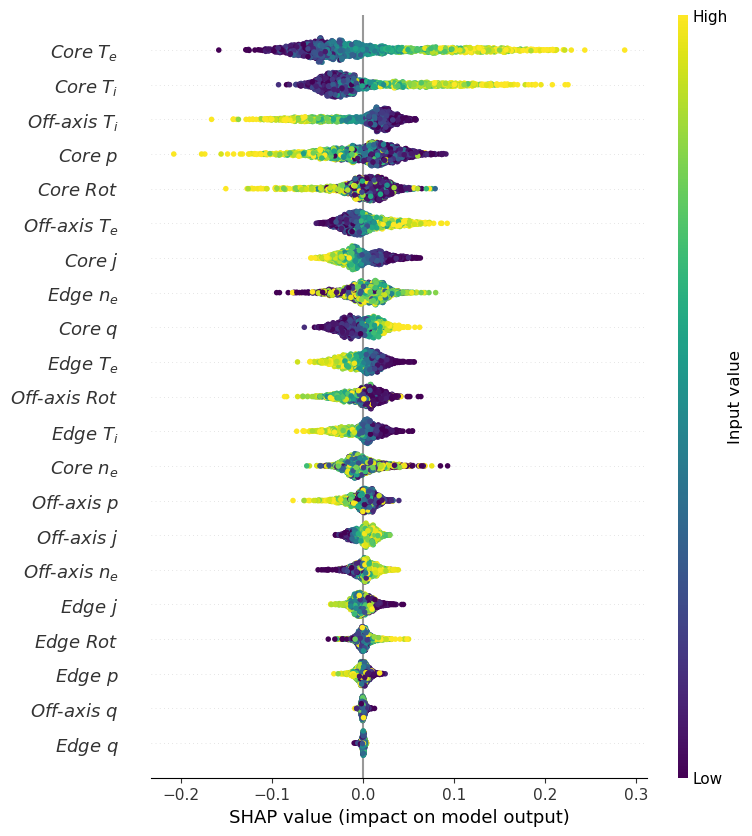

In [43]:
shap.plots.beeswarm(shap_values_copy, max_display=21, color_bar_label='Input value', log_scale=False, color='viridis', save_name='plots/TM_expt_beeswarm_2')

In [24]:
print(new_features)

['$Core$ $T_e$', '$Off$-$axis$ $T_e$', '$Edge$ $T_e$', '$Core$ $T_i$', '$Off$-$axis$ $T_i$', '$Edge$ $T_i$', '$Core$ $n_e$', '$Off$-$axis$ $n_e$', '$Edge$ $n_e$', '$Core$ $Rot$', '$Off$-$axis$ $Rot$', '$Edge$ $Rot$', '$Core$ $q$', '$Off$-$axis$ $q$', '$Edge$ $q$', '$Core$ $p$', '$Off$-$axis$ $p$', '$Edge$ $p$', '$Core$ $j$', '$Off$-$axis$ $j$', '$Edge$ $j$']


In [25]:
with open('/projects/EKOLEMEN/survival_tm_2/data/model0_norms.pkl', 'rb') as f:
    cake_normalizations_dict = pickle.load(f)
print(cake_normalizations_dict.keys())

dict_keys(['Te', 'Ti', 'ne', 'Vtor', '1/q', 'p', 'j'])


In [26]:
with open('figure_data/beeswarm_data_model23_2.pkl', 'wb') as f:
    pickle.dump(shap_values_copy, f)

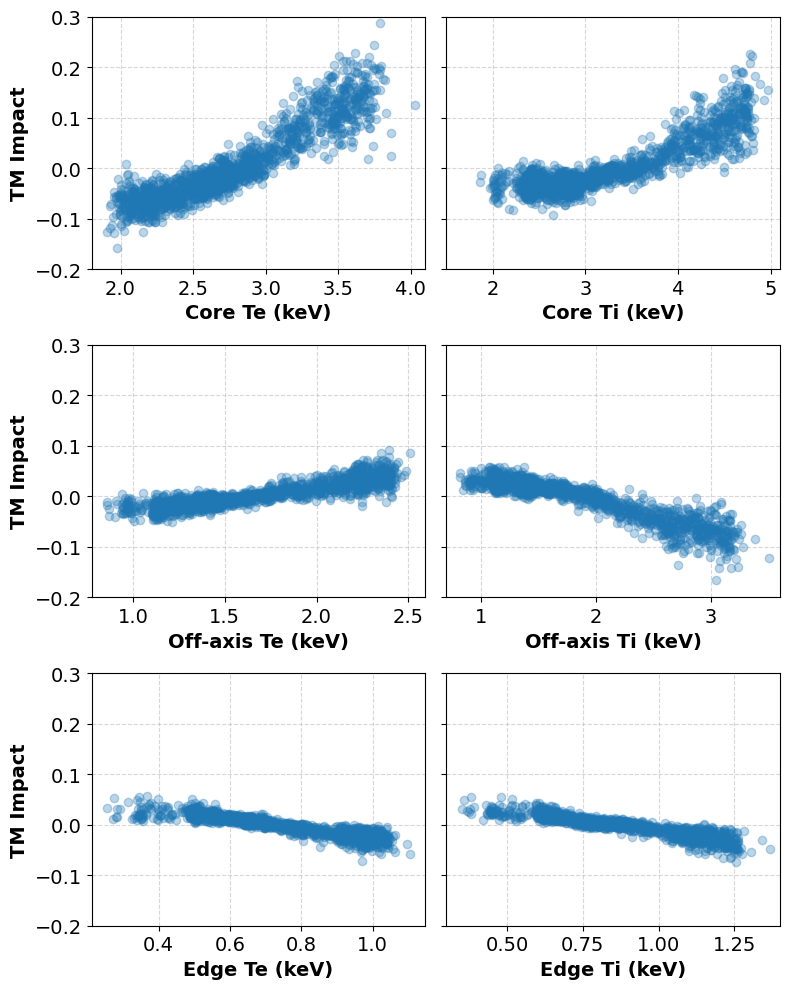

In [55]:
import matplotlib.pyplot as plt

# Define font size and weight
title_fontsize = 14
label_fontsize = 14
tick_fontsize = 14
font_weight = 'bold'

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(3, 2, figsize=(8, 10), sharey=True)

# Add grid to all subplots
for ax_row in axes:
    for ax in ax_row:
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_axisbelow(True)

# Scatter plots with Core Te (top-left) and Edge Te (top-right)
axes[0, 0].scatter(shap_values_copy.data[:, 0] * cake_normalizations_dict['Te']['std'] + cake_normalizations_dict['Te']['mean'],
                   shap_values_copy.values[:, 0], alpha=0.3)
axes[0, 0].set_xlabel('Core Te (keV)', fontsize=label_fontsize, fontweight=font_weight)
axes[0, 0].set_ylabel('TM Impact', fontsize=label_fontsize, fontweight=font_weight)
axes[0, 0].set_ylim([-0.2, 0.3])
axes[0, 0].set_xlim([1.8, 4.1])
axes[0, 0].tick_params(axis='both', labelsize=tick_fontsize)

axes[1, 0].scatter(shap_values_copy.data[:, 1] * cake_normalizations_dict['Te']['std'] + cake_normalizations_dict['Te']['mean'],
                   shap_values_copy.values[:, 1], alpha=0.3)
axes[1, 0].set_xlabel('Off-axis Te (keV)', fontsize=label_fontsize, fontweight=font_weight)
axes[1, 0].tick_params(axis='both', labelsize=tick_fontsize)
axes[1, 0].set_ylabel('TM Impact', fontsize=label_fontsize, fontweight=font_weight)

axes[2, 0].scatter(shap_values_copy.data[:, 2] * cake_normalizations_dict['Te']['std'] + cake_normalizations_dict['Te']['mean'],
                   shap_values_copy.values[:, 2], alpha=0.3)
axes[2, 0].set_xlabel('Edge Te (keV)', fontsize=label_fontsize, fontweight=font_weight)
axes[2, 0].tick_params(axis='both', labelsize=tick_fontsize)
axes[2, 0].set_ylabel('TM Impact', fontsize=label_fontsize, fontweight=font_weight)

# Scatter plots with Core Ti (bottom-left) and Edge Ti (bottom-right)
axes[0, 1].scatter(shap_values_copy.data[:, 3] * cake_normalizations_dict['Ti']['std'] + cake_normalizations_dict['Ti']['mean'],
                   shap_values_copy.values[:, 3], alpha=0.3)
axes[0, 1].set_xlabel(r'Core Ti (keV)', fontsize=label_fontsize, fontweight=font_weight)
axes[0, 1].set_xlim([1.5, 5.1])
axes[0, 1].tick_params(axis='both', labelsize=tick_fontsize)

axes[1, 1].scatter(shap_values_copy.data[:, 4] * cake_normalizations_dict['Ti']['std'] + cake_normalizations_dict['Ti']['mean'],
                   shap_values_copy.values[:, 4], alpha=0.3)
axes[1, 1].set_xlabel('Off-axis Ti (keV)', fontsize=label_fontsize, fontweight=font_weight)
axes[1, 1].tick_params(axis='both', labelsize=tick_fontsize)
axes[1, 1].set_xlim([0.7, 3.6])

axes[2, 1].scatter(shap_values_copy.data[:, 5] * cake_normalizations_dict['Ti']['std'] + cake_normalizations_dict['Ti']['mean'],
                   shap_values_copy.values[:, 5], alpha=0.3)
axes[2, 1].set_xlabel('Edge Ti (keV)', fontsize=label_fontsize, fontweight=font_weight)
axes[2, 1].tick_params(axis='both', labelsize=tick_fontsize)
axes[2, 1].set_xlim([0.3, 1.4])
# Global figure title
#fig.suptitle('TM Impact on Plasma Parameters', fontsize=title_fontsize, fontweight=font_weight)


# Adjust layout for readability
plt.tight_layout()

# Save figure (optional)
plt.savefig('plots/tm_impact_scatter_2.pdf', bbox_inches='tight')

# Show the figure
plt.show()


In [44]:
# denormalize specific shot x
with open('/projects/EKOLEMEN/survival_tm_2/data/model0_norms.pkl', 'rb') as f:
    cake_normalizations_dict = pickle.load(f)
prof_signals = ['Te', 'Ti', 'ne', 'Vtor', '1/q', 'p', 'j']
denormalized_x = copy.deepcopy(x)
for i, profile in enumerate(prof_signals):
    denormalized_x[:, i*33:(i+1)*33] = x[:, i*33:(i+1)*33] * cake_normalizations_dict[profile]['std'] + cake_normalizations_dict[profile]['mean']
# take reciprocal of 1/q 
denormalized_x[:, 4*33: 5*33] = np.where(denormalized_x[:, 4*33: 5*33] != 0, 1 / denormalized_x[:, 4*33: 5*33], 0)

# LP filter the shap values and x in time
shap_values_filtered = copy.deepcopy(shap_values.values)
for i in range(shap_values_filtered.shape[1]):
    shap_values_filtered[:, i] = metrics_helpers.LP_filter(shap_values.values[:, i], alpha=0.64)
denormalized_x_filtered = copy.deepcopy(x)
for i in range(denormalized_x_filtered.shape[1]):
    denormalized_x_filtered[:, i] = metrics_helpers.LP_filter(denormalized_x[:, i], alpha=0.64)

/tmp/ipykernel_325466/2800355168.py:9: RuntimeWarning: divide by zero encountered in divide
  denormalized_x[:, 4*33: 5*33] = np.where(denormalized_x[:, 4*33: 5*33] != 0, 1 / denormalized_x[:, 4*33: 5*33], 0)


In [45]:
complete_shap_dict = {'shap_values': shap_values, 'model_output': model_output[keep_inds], 'x': x[keep_inds], 'shots_list': shots_list[keep_inds], 'times_list': times_list[keep_inds]}

complete_shap_dict['shap_values_filtered'] = shap_values_filtered
complete_shap_dict['denormalized_x_filtered'] = denormalized_x_filtered[keep_inds]
with open(f'figure_data/complete_shap_dict_2_model23_2.pkl', 'wb') as f:
    pickle.dump(complete_shap_dict, f)

In [31]:
wanted_shot = '199607'

start_index = np.where(shots_list == wanted_shot)[0][0]
end_index = len(shots_list) - 1 - np.where(shots_list[::-1] == wanted_shot)[0][0]

specific_shot_x = x[start_index:end_index]
denormalized_specific_shot_x_filtered = denormalized_x_filtered[start_index:end_index]
specific_shot_times = times_list[start_index:end_index]
specific_shot_shap_values_filtered = shap_values_filtered[start_index:end_index]

[ 260  280  300  320  340  360  380  400  420  440  460  480  500  520
  540  560  580  600  620  640  660  680  700  720  740  760  780  800
  820  840  860  880  900  920  940  960  980 1000 1020 1040 1060 1080
 1100 1120 1140 1160 1180 1200 1220 1240 1260 1280 1300 1320 1340 1360
 1380 1400 1420 1440 1460 1480 1500 1520 1540 1560 1580 1600 1620 1640
 1660 1680 1700 1720 1740 1760 1780 1800 1820 1840 1860 1880 1900 1920
 1940 1960 1980 2000 2020 2040 2120 2140 2220 2240 2320 2340 2420 2440
 2520 2540 2620 2640 2720 2740 2820 2840 2920 2940 3020 3040 3120 3140
 3220 3240 3320 3340 3420 3440 3520 3540 3620 3640 3720 3740 3820 3840
 3920 3940 4020 4040 4120 4140 4220 4240 4320 4340 4420 4440 4520 4540
 4620 4640 4720 4740 4820 4840 4920 4940 5020 5040 5060 5080 5100 5120
 5140 5160 5180 5200 5220 5240 5260 5280 5300 5320 5340 5360 5380 5400
 5420 5440 5460 5480 5500]


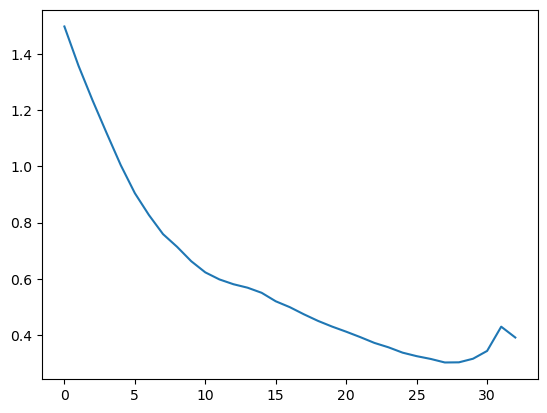

In [36]:
plt.plot(denormalized_specific_shot_x_filtered[100, 6*33:7*33])
print(specific_shot_times)

In [5]:
with open('data/j_eccd_q2.pkl', 'rb') as f:
    j_eccd_dict = pickle.load(f)
eccd_time = j_eccd_dict['time']
eccd_j = j_eccd_dict['JECCD_q=2']

In [6]:
import matplotlib.pyplot as plt

# Example data: 
# 'specific_shot_times' is your time array
# 'model_output' is the data for the black line on the left axis
# 'second_data' is the data for the light-blue line on the right axis
# start_index, end_index, wanted_shot are already defined in your code

# Low-pass filter for the main line (reuse your function):
filtered_model_output = metrics_helpers.LP_filter(model_output[start_index:end_index], alpha=0.64)

# Example second-data array (replace with your actual data):
second_data =eccd_j

fig, ax = plt.subplots(figsize=(8, 3))
# set general fontsize
plt.rcParams.update({'font.size': 14})
# --- Left Y-axis (ax) ---
ax.plot(
    specific_shot_times, 
    filtered_model_output, 
    color='black', 
    linewidth=3,
    label='TM Probability'
)
ax.fill_between(
    specific_shot_times,
    filtered_model_output[:, 0], 
    color='gray', 
    alpha=0.4
)

# Labeling and limits for the left axis
ax.set_xlabel('Time (ms)', fontweight='bold')
ax.set_ylabel('TM Probability', fontweight='bold')
ax.set_xlim(1000, 5000)
ax.set_ylim(0, 0.5)
ax.set_title(f'Stable Controlled Shot {wanted_shot}')

# --- Right Y-axis (ax2) ---
ax2 = ax.twinx()  # Create a second y-axis sharing the same x-axis
ax2.plot(
    eccd_time, 
    second_data/1000, 
    color='#e95c5c', 
    linewidth=2, 
)
ax2.set_ylim(0, 150)
# Labeling and limits for the right axis
ax2.set_ylabel('J$\mathbf{_{ECCD}}$ at q=2 (kA/m$\mathbf{^2}$)', color='#e95c5c', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#e95c5c')
# e.g., set your own y-limits here:
# ax2.set_ylim(0, 1.0)
ind1 = 110
ind2 = 124
new_prof_signals = ['Te', 'Ti', 'ne', 'Vtor', 'q', 'p', 'j']
time_indices = [ind1, ind2]
colors = ['blue', 'green']
for n, ind in enumerate(time_indices):
    plt.axvline(x=specific_shot_times[ind], color = colors[n], linestyle='--', linewidth=2, label=f't{n+1} = {specific_shot_times[ind]} ms')
plt.legend(loc='upper right', fontsize='11')
plt.tight_layout()
plt.savefig('plots/survival_j_eccd.pdf', bbox_inches='tight')
plt.show()


NameError: name 'model_output' is not defined

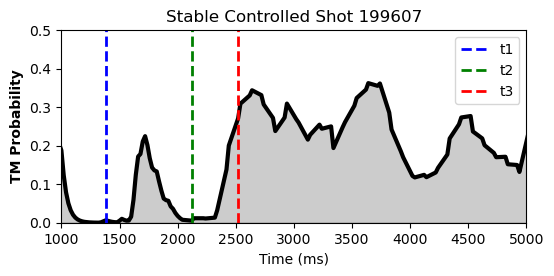

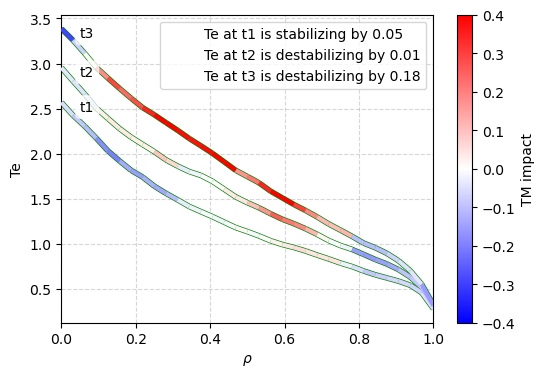

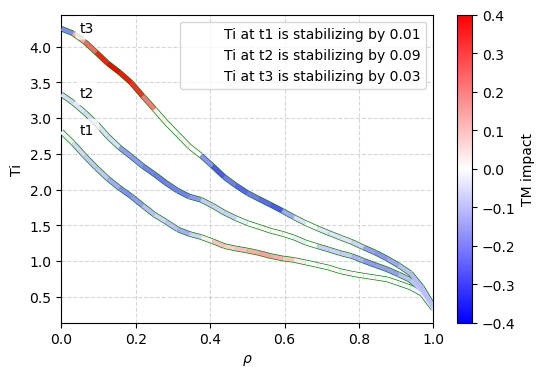

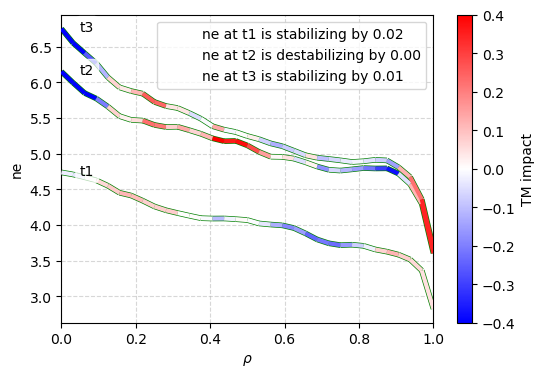

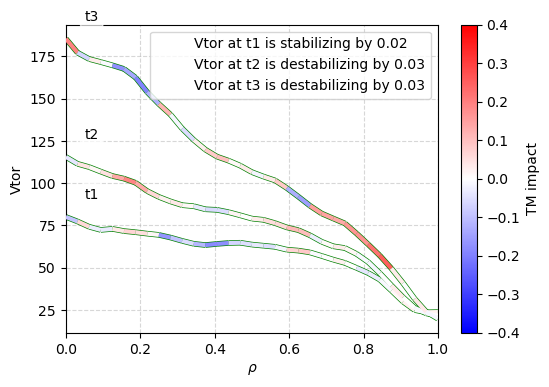

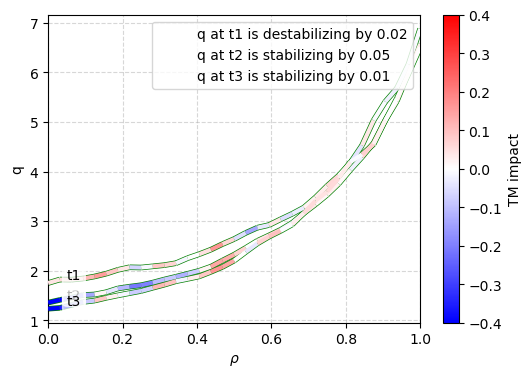

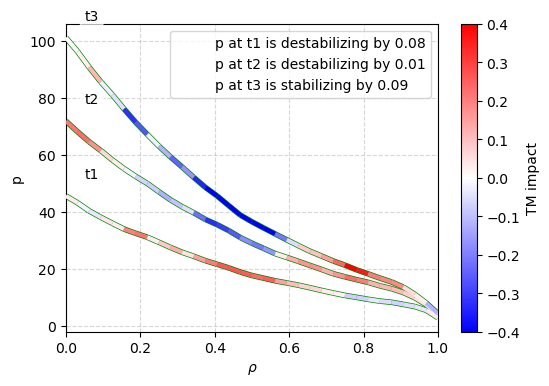

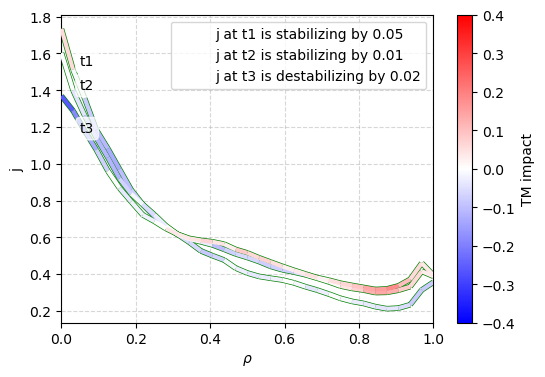

In [77]:
import plotting_helpers
ind1 = 56
ind2 = 90
ind3 = 98
new_prof_signals = ['Te', 'Ti', 'ne', 'Vtor', 'q', 'p', 'j']
time_indices = [ind1, ind2, ind3]
averaging_window_size = 7
# make the line thicker and black.
plt.figure(figsize=(6, 2.5))
plt.plot(specific_shot_times, metrics_helpers.LP_filter(model_output[start_index:end_index], alpha=0.64), color='black', linewidth=3)
plt.fill_between(specific_shot_times, metrics_helpers.LP_filter(model_output[start_index:end_index], alpha=0.64)[:, 0], color='gray', alpha=0.4)
plt.xlabel('Time (ms)')
plt.ylabel('TM Probability', fontweight='bold')
plt.xlim(1000, 5000)
plt.ylim(0, 0.5)
plt.title(f'Stable Controlled Shot {wanted_shot}')
# change figure long
ax = plt.gca()  # get current Axes
x_min, x_max = ax.get_xlim()
#ax.axvspan(2800, 5000, color='red', alpha=0.2, label='Tearing mode appears')

colors = ['blue', 'green', 'red']
for n, ind in enumerate(time_indices):
    plt.axvline(x=specific_shot_times[ind], color = colors[n], linestyle='--', linewidth=2, label=f't{n+1}')
plt.legend()
plt.savefig(f'plots/{wanted_shot}_probability.svg', bbox_inches='tight')
# multiply shap_values_filtered by 33 to get the full profile values
for i in range(len(new_prof_signals)):
    plotting_helpers.plot_3_profiles_heatmaps(np.linspace(0, 1, 33), i, new_prof_signals, denormalized_specific_shot_x_filtered, specific_shot_shap_values_filtered*33, time_indices, title='', averaging_window_size = averaging_window_size, save_name=f"{wanted_shot}_shap_{new_prof_signals[i]}")

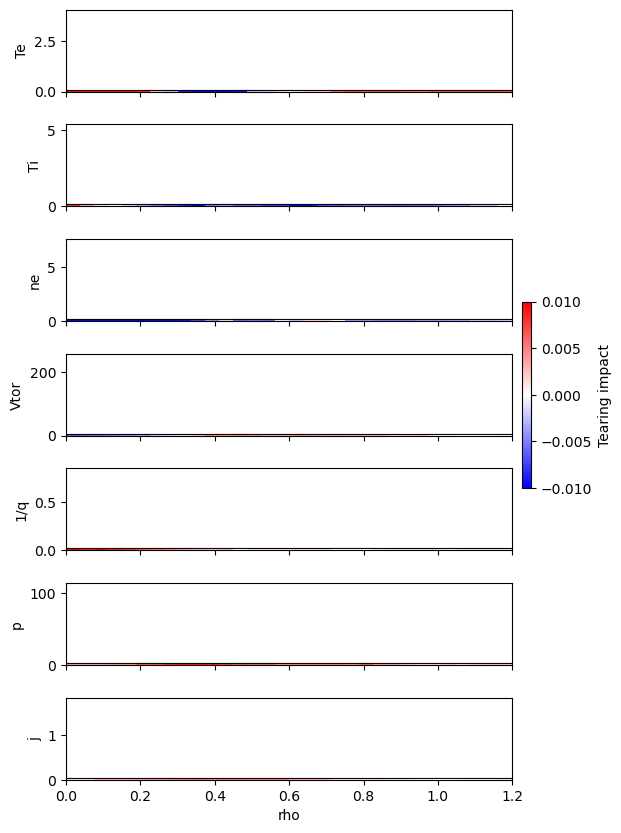

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.animation import FuncAnimation
import matplotlib.patheffects as path_effects
def rolling_average(arr, window_size):
    if window_size % 2 == 0:
        raise ValueError("Window size must be odd.")
    return np.convolve(
        np.pad(arr, window_size // 2, mode='edge'),
        np.ones(window_size) / window_size,
        mode='valid'
    )

# Your signals and profiles
prof_signals = ['Te', 'Ti', 'ne', 'Vtor', '1/q', 'p', 'j']
signals = ['bmspinj', 'bmstinj', 'betan_EFITRT2', 'qmin_EFITRT2', 'ech_pwr_total', 
           'ip', 'PCBCOIL', 'li_EFITRT2', 'aminor_EFITRT2', 'rmaxis_EFITRT2', 
           'tribot_EFITRT2', 'tritop_EFITRT2', 'kappa_EFITRT2', 'volume_EFITRT2']
signals = []
# Assume you have:
# expanded_specific_shot_x: shape (num_timesteps, something)
# expanded_shap_values: shape (num_timesteps, something, something)
# Each profile has 121 points, and starts at index n_scalars + i*121 for the i-th profile.
# Adjust these variables as per your actual data:
timestep_start = 0
timestep_end = 195  # For example, animate from timestep 0 to 199
num_timesteps = timestep_end - timestep_start
n_scalars = len(signals)
num_points_per_profile = 33
x = np.linspace(0, 1.2, num_points_per_profile)

# Create a bright red-to-blue colormap
bright_red_blue = LinearSegmentedColormap.from_list("BrightRdBu", ["blue", "white", "red"], N=256)

# Create the figure and subplots for the 7 profiles
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(6, 10), sharex=True)
fig.subplots_adjust(hspace=0.4)

# We'll store a LineCollection for each profile
line_collections = []

# Initial data for the first timestep
t0 = timestep_start
for i, profile in enumerate(prof_signals):
    # Extract the data for the first timestep
    temperature = denormalized_specific_shot_x_filtered[t0, n_scalars + i*num_points_per_profile : n_scalars + (i+1)*num_points_per_profile]
    density = -1 * rolling_average(shap_values_filtered[t0, n_scalars + i*num_points_per_profile : n_scalars + (i+1)*num_points_per_profile], 17)

    # Create segments for the line
    points = np.array([x, temperature]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create the LineCollection
    #lc = LineCollection(segments, cmap=bright_red_blue, norm=plt.Normalize(vmin=np.min(shap_values_filtered)/2, vmax=np.max(shap_values_filtered)/2))
    lc = LineCollection(segments, cmap=bright_red_blue, norm=plt.Normalize(vmin=-0.01, vmax=0.01))
    lc.set_array(density)
    lc.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),  # "border"
        path_effects.Normal()
    ])
    ax = axes[i]
    ax.add_collection(lc)
    ax.set_ylabel(profile)

    # Set axis limits (you can adjust if needed)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(denormalized_specific_shot_x[:, n_scalars + i*num_points_per_profile : n_scalars + (i+1)*num_points_per_profile].min(), denormalized_specific_shot_x[:, n_scalars + i*num_points_per_profile : n_scalars + (i+1)*num_points_per_profile].max())

    # Store the line collection
    line_collections.append(lc)

# Add a shared x-label
axes[-1].set_xlabel('rho')

# Add a colorbar for density on one of the axes (e.g. the first one)
cbar = fig.colorbar(line_collections[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('Tearing impact')

# Animation update function
def update(frame):
    t = timestep_start + frame
    # Update each profile line collection
    for i, lc in enumerate(line_collections):
        temperature = denormalized_specific_shot_x_filtered[t, n_scalars + i*num_points_per_profile : n_scalars + (i+1)*num_points_per_profile]
        density = -1 * rolling_average(shap_values_filtered[t, n_scalars + i*num_points_per_profile : n_scalars + (i+1)*num_points_per_profile], 17)

        points = np.array([x, temperature]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Update the segments and array
        lc.set_segments(segments)
        lc.set_array(density)
        lc.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),  # "border"
        path_effects.Normal()
    ])
        # If temperature range changes with time, you might want to rescale y-limits:
        #axes[i].set_ylim(temperature.min(), temperature.max())
    fig.suptitle(f'{specific_shot_t[t]}ms to TM, P(TM)={1-metrics_helpers.LP_filter(model_output[t])}')

    return line_collections

ani = FuncAnimation(fig, update, frames=num_timesteps, interval=1000)

plt.show()

# If you want to save the animation (requires ffmpeg):
ani.save('7_profiles_animation_border.mp4', writer='ffmpeg', fps=10)


In [21]:
general_explainer = shap.Explainer(numpy_model, data, feature_names=feature_names)
general_shap_values = general_explainer(data)

PermutationExplainer explainer: 196it [01:03,  2.64it/s]                         


In [39]:
print(general_shap_values[50])

IndexError: list index out of range

In [39]:
partition_explainer = shap.PartitionExplainer(numpy_model, data, feature_names=feature_names)
partition_shap_values = general_explainer(data)

PermutationExplainer explainer: 174it [00:25,  4.22it/s]                         


In [26]:
print(shap_values[0].shape)

(231,)


In [34]:
shap.plots.force(shap_values[0])

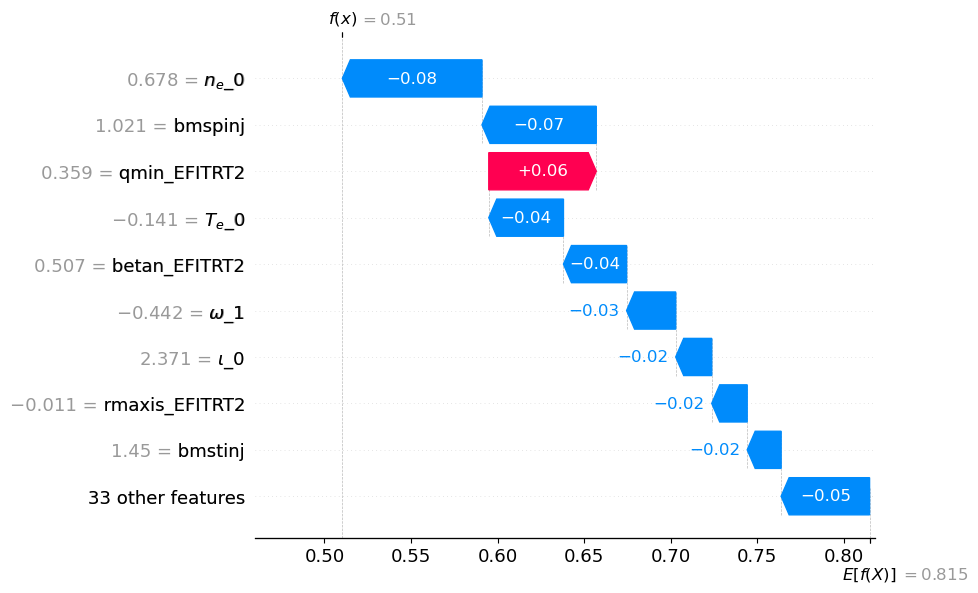

In [57]:
shap.plots.waterfall(general_shap_values[100, :])

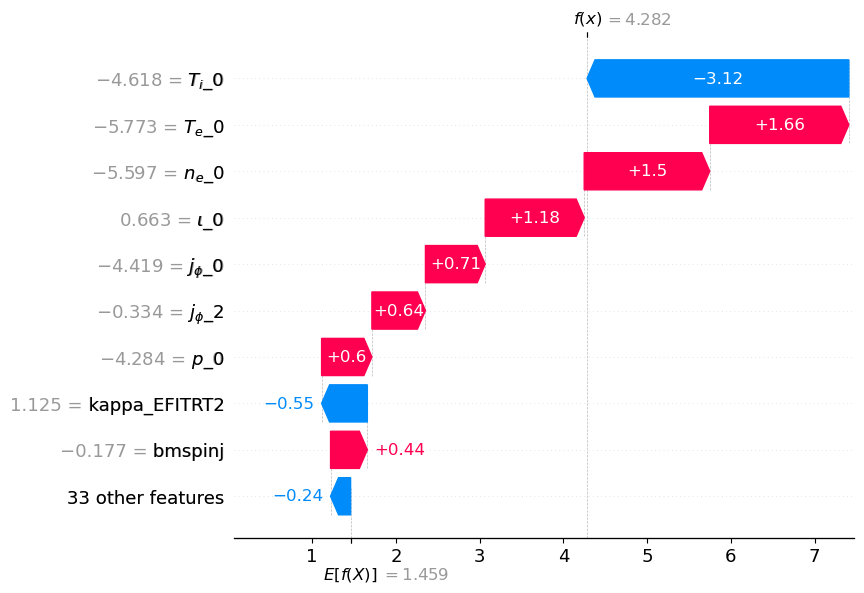

In [61]:
shap.plots.waterfall(shap_values[0, :, 0])

CONVERT SHAP TO PCA PROFILE

In [17]:
with open('/home/hf8585/TMPredictor/survival_tm/TearingModeSurvival/data/cake_normalizations_dict.pkl', 'rb') as f:
    normalizations = pickle.load(f)

In [16]:
def pca_to_profile(pca_matrix, pca_values, mean_profile):
    '''
    pca_matrix: the matrix used to perform PCA (n_pca, len(profile))
    pca_values: the PCA values to convert to a profile (n_times, n_pca)
    mean_profile: the mean profile to add to the PCA values (len(profile))

    returns: each pca profile (n_times, n_pca, len(profile))
    returns: the reconstructed profile (n_times, len(profile))
    '''
    n_times = pca_values.shape[0]
    n_pca = pca_values.shape[1]
    n_features = mean_profile.shape[0]
    # Initialize array to store contributions from each PCA component
    profile_per_pca = np.zeros((n_times, n_pca, n_features))

    # Compute the contribution of each PCA component
    for i in range(n_pca):
        # Outer product of PCA scores for component i with its eigenvector
        profile_per_pca[:, i, :] = np.outer(pca_values[:, i], pca_matrix[i, :])

    # Add the mean profile to all time steps
    full_profile = np.sum(profile_per_pca, axis=1) + mean_profile

    return profile_per_pca, full_profile

In [10]:
### convert PCA shap into profile shap

pca_shap_to_profile = pca_to_profile(Te_pca_matrix, profile_shap_values[:, :4], np.zeros(121))

'''profile_shap_values = shap_values.values[:, len(scalar_signals):]
pca_shap_to_profile = 0
Te_pca_matrix = normalizations['Te']['pca_matrix']
print((Te_pca_matrix[i, :]*profile_shap_values[:, i]).shape)
for i in range(4):
    pca_shap_to_profile += Te_pca_matrix[i, :]*profile_shap_values[:, i]'''

NameError: name 'pca_to_profile' is not defined

/tmp/ipykernel_1017870/2106178894.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(pca_shap_to_profile[1][0,:]/Te_pca_mean, label='Full/Te_mean')
/tmp/ipykernel_1017870/2106178894.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(pca_shap_to_profile[0][0, i, :]/Te_pca_mean, label=f'PCA {i}/Te_mean')


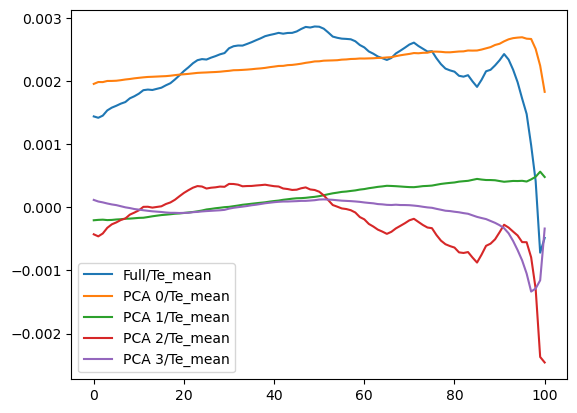

In [129]:
plt.plot(pca_shap_to_profile[1][0,:]/Te_pca_mean, label='Full/Te_mean')
for i in range(4):
    plt.plot(pca_shap_to_profile[0][0, i, :]/Te_pca_mean, label=f'PCA {i}/Te_mean')
plt.legend()

MAKE NEW MODEL WITH PCA LAYER

In [15]:
class Model_with_pca_layer(torch.nn.Module):
    def __init__(self, normalizations, base_model):
        """
        :normalizations: PCA components matrix (torch.Tensor of shape [n_pca_components, n_features])
        :param mean: Mean vector used in PCA (torch.Tensor of shape [n_features])
        :param base_model: PyTorch model that takes PCA components as input
        """
        super(Model_with_pca_layer, self).__init__()
        self.normalizations = normalizations  # PCA components
        self.base_model = base_model  # Existing PyTorch model
    def forward(self, x):
        # Step 3: Apply PCA transformation
        profile_size = 121
        profile_number = 7
        n_scalars = x.shape[1] - profile_size*profile_number
        x_profiles = x[:, n_scalars:]
        x_pca = torch.zeros(x_profiles.shape[0], n_scalars + 4*profile_number)
        x_pca[:, :n_scalars] = x[:, :n_scalars]
        profile_keys = list(self.normalizations.keys())[n_scalars:]
        for i, profile in enumerate(profile_keys):
            this_profile = x_profiles[:, profile_size*i:profile_size*(i+1)]
            x_centered = this_profile - self.normalizations[profile]['pca_mean']  # Center the input
            x_pca[:, n_scalars + 4*i:n_scalars + 4*(i+1)] = torch.matmul(x_centered, torch.tensor(self.normalizations[profile]['pca_matrix'].T))  # Project onto PCA components
        # Step 4: Pass the PCA-transformed data to the base model
        return self.base_model(x_pca.double(), risk=-1)

CONVERT PCA DATA TO PROFILE DATA

In [18]:
torch_specific_shot_x = torch.Tensor(np.array(specific_shot_x))
n_scalars = torch_specific_shot_x.shape[1] - 4*7

expanded_specific_shot_x = torch.zeros(torch_specific_shot_x.shape[0], n_scalars + 7*121)
### de-pca the array
print(torch_specific_shot_x)
print(expanded_specific_shot_x.shape)
expanded_specific_shot_x[:, :n_scalars] = torch_specific_shot_x[:, :n_scalars]
for i, profile in enumerate(list(normalizations.keys())[n_scalars:]):
    a = pca_to_profile(normalizations[profile]['pca_matrix'], torch_specific_shot_x[:, n_scalars + i*4: n_scalars + (i+1)*4], normalizations[profile]['pca_mean'])[1]
    expanded_specific_shot_x[:, n_scalars + i*121:n_scalars + (i+1)*121] = torch.Tensor(a)

tensor([[-0.1771,  0.3489, -1.0952,  ...,  1.0503, -0.3338,  0.0263],
        [-0.2319,  0.2784, -1.0952,  ...,  0.3970, -0.0758, -0.1103],
        [-0.4450,  0.0438, -0.6576,  ...,  0.3330, -0.0569, -0.1111],
        ...,
        [ 1.0006,  1.5129,  2.3408,  ..., -0.3013,  0.1723, -0.1271],
        [ 1.5987,  2.1591,  2.1803,  ..., -0.3042,  0.1842, -0.1444],
        [ 2.0479,  2.5940,  2.2684,  ..., -0.3080,  0.1959, -0.1371]])
torch.Size([129, 861])


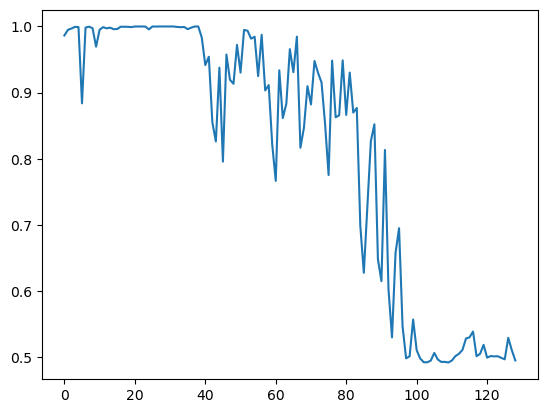

In [19]:
test_model = Model_with_pca_layer(normalizations, torch_model)
plt.plot(test_model.forward(expanded_specific_shot_x))

In [13]:
# Define the lambda function to convert input to tensor, pass through the model, and return a numpy array
from torch.autograd import Variable
g = lambda x: torch.tensor(test_model(Variable(torch.tensor(x)))).detach().numpy()

g(expanded_specific_shot_x)

NameError: name 'expanded_specific_shot_x' is not defined

In [20]:
def numpy_model_2(x):

    input_tensor = torch.tensor(x)
    
    # Wrap the tensor in a Variable (optional, often not necessary in PyTorch 1.0+)
    #input_tensor = Variable(input_tensor)
    
    # Pass the input through the PyTorch model
    model_output = test_model(input_tensor)
    # Convert the output to a NumPy array
    output_array = torch.tensor(model_output).detach().numpy()
    
    return output_array

In [21]:
explainer = shap.KernelExplainer(numpy_model_2, np.array(expanded_specific_shot_x))

expanded_shap_values = explainer(np.array(expanded_specific_shot_x))

Using 129 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 129/129 [23:44<00:00, 11.04s/it]


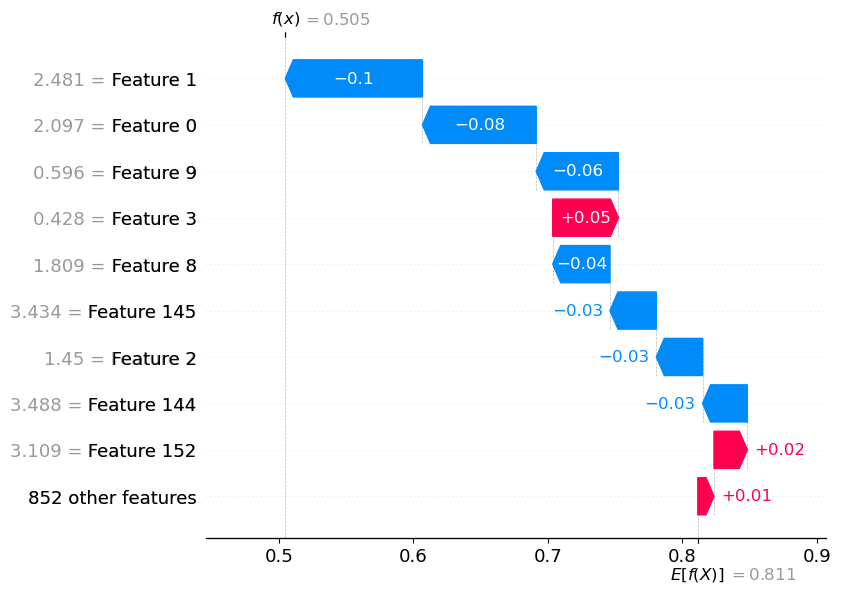

In [120]:
shap.plots.waterfall(expanded_shap_values[112, :, 0])

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

def plot_temperature_density(x, temperature, density, profile=""):
    """
    Plots Temperature vs Radial Position with line segments colored by Density.
    
    Args:
        x (array-like): Radial positions.
        temperature (array-like): Temperature values corresponding to `x`.
        density (array-like): Density values corresponding to `x`.
        title (str): Title of the plot.
    """
    # Define a bright red-to-blue colormap
    bright_red_blue = LinearSegmentedColormap.from_list("BrightRdBu", ["blue", "white", "red"], N=256)

    # Create segments for the line
    points = np.array([x, temperature]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection, with colors mapped to density
    lc = LineCollection(segments, cmap=bright_red_blue, norm=plt.Normalize(vmin=min(density), vmax=max(density)))
    lc = LineCollection(segments, cmap=bright_red_blue, norm=plt.Normalize(vmin=-0.01, vmax=0.01))

    lc.set_array(density)  # Set density values to color the segments

    # Create the plot
    fig, ax = plt.subplots(figsize=(4, 2))
    line = ax.add_collection(lc)
    ax.plot(x, temperature, alpha=0)  # Add an invisible line for proper axis scaling

    # Add a colorbar for density
    colorbar = plt.colorbar(line, ax=ax)
    colorbar.set_label('Tearing impact')

    # Set axis limits and labels
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(temperature.min(), temperature.max())
    ax.set_xlabel('rho')
    ax.set_ylabel(profile)
    #ax.set_title(title)

    # Show the plot
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    
def rolling_average(arr, window_size):
    """
    Computes the rolling average of a 1D array.
    """
    if window_size % 2 == 0:
        raise ValueError("Window size must be odd.")
    return np.convolve(np.pad(arr, window_size // 2, mode='edge'), 
                       np.ones(window_size) / window_size, mode='valid')

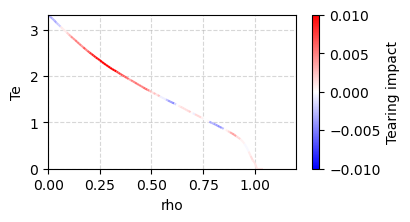

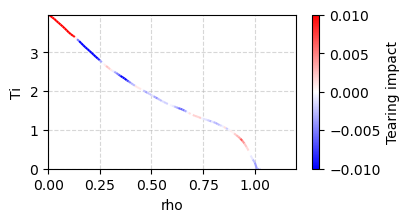

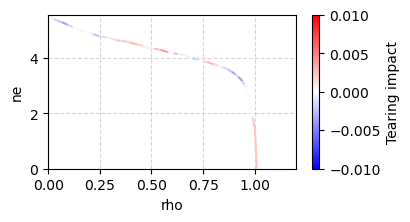

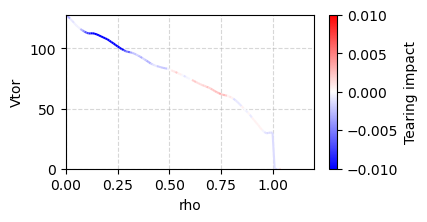

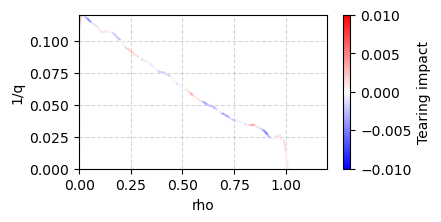

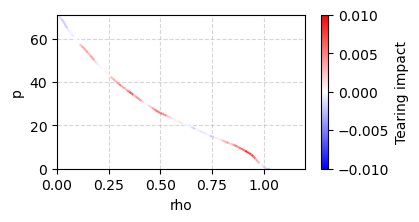

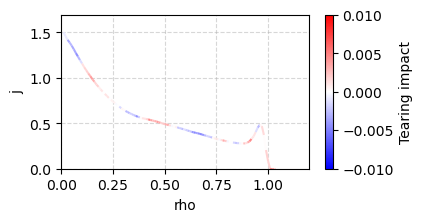

In [26]:
prof_signals = ['Te', 'Ti', 'ne', 'Vtor', '1/q', 'p', 'j']
signals = ['bmspinj', 'bmstinj', 'betan_EFITRT2', 'qmin_EFITRT2', 'ech_pwr_total', 'ip', 'PCBCOIL', 'li_EFITRT2', 'aminor_EFITRT2', 
          'rmaxis_EFITRT2', 'tribot_EFITRT2', 'tritop_EFITRT2', 'kappa_EFITRT2', 'volume_EFITRT2']
timestep = 113
n_scalars = len(signals)
for i, profile in enumerate(prof_signals):
    plot_temperature_density(np.linspace(0, 1.2, 121), expanded_specific_shot_x[timestep, n_scalars + i*121:n_scalars + (i+1)*121], -1*rolling_average(expanded_shap_values[timestep, n_scalars + i*121:n_scalars + (i+1)*121, 0].values, 7), profile=profile)

In [47]:
print(shap_values.values.shape)

(195, 231)


/tmp/ipykernel_1171471/3155521580.py:65: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(temperature.min(), temperature.max())


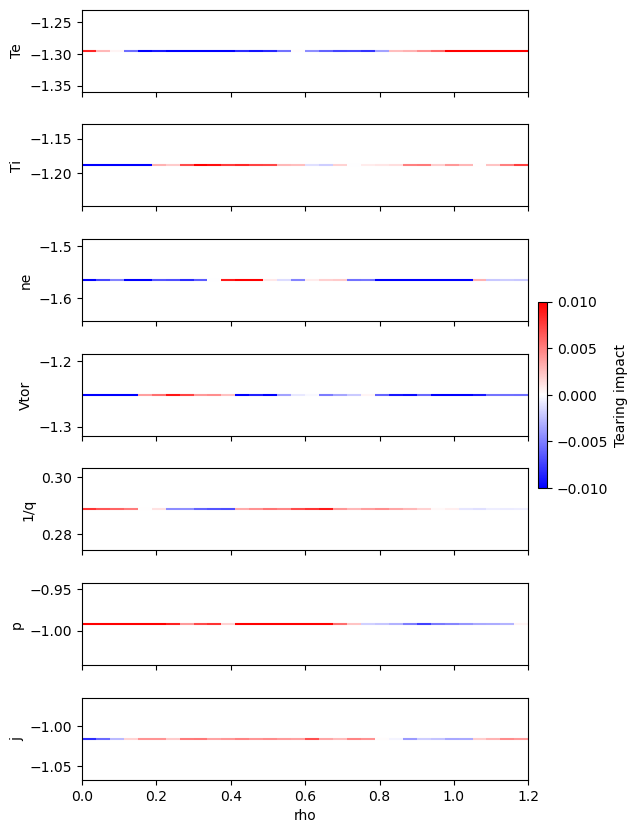

/tmp/ipykernel_1171471/3155521580.py:93: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim(temperature.min(), temperature.max())


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.animation import FuncAnimation

def rolling_average(arr, window_size):
    if window_size % 2 == 0:
        raise ValueError("Window size must be odd.")
    return np.convolve(
        np.pad(arr, window_size // 2, mode='edge'),
        np.ones(window_size) / window_size,
        mode='valid'
    )

# Your signals and profiles
prof_signals = ['Te', 'Ti', 'ne', 'Vtor', '1/q', 'p', 'j']
signals = ['bmspinj', 'bmstinj', 'betan_EFITRT2', 'qmin_EFITRT2', 'ech_pwr_total', 
           'ip', 'PCBCOIL', 'li_EFITRT2', 'aminor_EFITRT2', 'rmaxis_EFITRT2', 
           'tribot_EFITRT2', 'tritop_EFITRT2', 'kappa_EFITRT2', 'volume_EFITRT2']
signals = []
# Assume you have:
# expanded_specific_shot_x: shape (num_timesteps, something)
# expanded_shap_values: shape (num_timesteps, something, something)
# Each profile has 121 points, and starts at index n_scalars + i*121 for the i-th profile.
# Adjust these variables as per your actual data:
timestep_start = 0
timestep_end = 100  # For example, animate from timestep 0 to 199
num_timesteps = timestep_end - timestep_start
n_scalars = len(signals)
num_points_per_profile = 33
x = np.linspace(0, 1.2, num_points_per_profile)

# Create a bright red-to-blue colormap
bright_red_blue = LinearSegmentedColormap.from_list("BrightRdBu", ["blue", "white", "red"], N=256)

# Create the figure and subplots for the 7 profiles
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(6, 10), sharex=True)
fig.subplots_adjust(hspace=0.4)

# We'll store a LineCollection for each profile
line_collections = []

# Initial data for the first timestep
t0 = timestep_start
for i, profile in enumerate(prof_signals):
    # Extract the data for the first timestep
    temperature = specific_shot_x[t0, n_scalars + i*num_points_per_profile : n_scalars + (i+1)*num_points_per_profile]
    density = -1 * rolling_average(shap_values.values[t0, n_scalars + i*num_points_per_profile : n_scalars + (i+1)*num_points_per_profile], 7)

    # Create segments for the line
    points = np.array([x, temperature]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create the LineCollection
    lc = LineCollection(segments, cmap=bright_red_blue, norm=plt.Normalize(vmin=-0.01, vmax=0.01))
    lc.set_array(density)

    ax = axes[i]
    ax.add_collection(lc)
    ax.set_ylabel(profile)

    # Set axis limits (you can adjust if needed)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(temperature.min(), temperature.max())

    # Store the line collection
    line_collections.append(lc)

# Add a shared x-label
axes[-1].set_xlabel('rho')

# Add a colorbar for density on one of the axes (e.g. the first one)
cbar = fig.colorbar(line_collections[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('Tearing impact')

# Animation update function
def update(frame):
    t = timestep_start + frame
    # Update each profile line collection
    for i, lc in enumerate(line_collections):
        temperature = specific_shot_x[t, n_scalars + i*num_points_per_profile : n_scalars + (i+1)*num_points_per_profile]
        density = -1 * rolling_average(shap_values.values[t, n_scalars + i*num_points_per_profile : n_scalars + (i+1)*num_points_per_profile], 7)

        points = np.array([x, temperature]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Update the segments and array
        lc.set_segments(segments)
        lc.set_array(density)

        # If temperature range changes with time, you might want to rescale y-limits:
        axes[i].set_ylim(temperature.min(), temperature.max())

    return line_collections

ani = FuncAnimation(fig, update, frames=num_timesteps, interval=200)

plt.show()

# If you want to save the animation (requires ffmpeg):
ani.save('7_profiles_animation.mp4', writer='ffmpeg', fps=5)


In [27]:
print(expanded_specific_shot_x.shape)
print(expanded_shap_values.shape)

torch.Size([129, 861])
(129, 861, 1)
